In [2]:
import re
import string
import numpy as np 
import random
import pandas as pd 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

In [3]:
train = pd.read_csv('train.csv')

In [4]:
train.shape

(31962, 3)

In [5]:
train.head()

,id,label,tweet
0,1,0,@user when a father is dysfunctional and is s...
1,2,0,@user @user thanks for #lyft credit i can't us...
2,3,0,bihday your majesty
3,4,0,#model i love u take with u all the time in ...
4,5,0,factsguide: society now #motivation


Exploratory Data Analysis

In [6]:
train['label'].value_counts()

0    29720
1     2242
Name: label, dtype: int64

<AxesSubplot:xlabel='label', ylabel='count'>

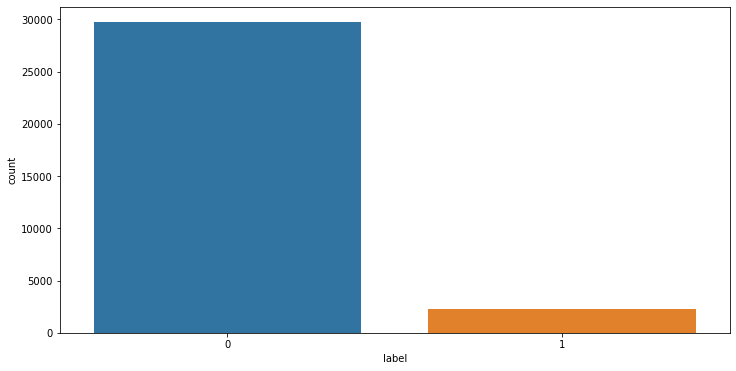

In [7]:
plt.figure(figsize=(12,6))
sns.countplot(x='label',data=train)

In [8]:
import nltk
from nltk.stem import WordNetLemmatizer
lemma = WordNetLemmatizer()
nltk.download('stopwords')
from nltk.corpus import stopwords

[nltk_data] Downloading package stopwords to C:\Users\Sai Ram
[nltk_data]     Pendyala\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [9]:
def transform_text(text):
    text = text.lower()
    
    r = re.findall('@[\w]*', text)
    
    for w in r:
        text = text.replace(w, ' ')
    text = text.replace('[^a-zA-Z#]', '')
    text = ' '.join([word for word in text.split() if len(word) > 3])
    
    text = re.sub(r'\$%,.\:\?', ' ', text)
    text = re.sub(r'\s+', ' ', text)
    
    words = text.split(" ")
    words = [lemma.lemmatize(word) for word in words if word not in set(stopwords.words('english'))]
    text = ' '.join(words) 
    
    return text

In [11]:
train['clean_text'] = train['tweet'].apply(lambda x : transform_text(x))

In [12]:
train.sample(5)

,id,label,tweet,clean_text
27199,27200,0,i don't know what the point in twitter is i'm ...,know point twitter talking even like retweets ...
28808,28809,0,wo aakhri pal ..... moment ððð #kun...,aakhri ..... moment ððð #kunjsarnað...
21545,21546,0,#macedonians #ransack presidentâs #office ...,#macedonians #ransack presidentâs #office #o...
14286,14287,1,now ask yourself if you really want to follow ...,really want follow done.
26702,26703,0,49 people were killed and 53 injured in the #a...,people killed injured #attack #gay nightclub #...


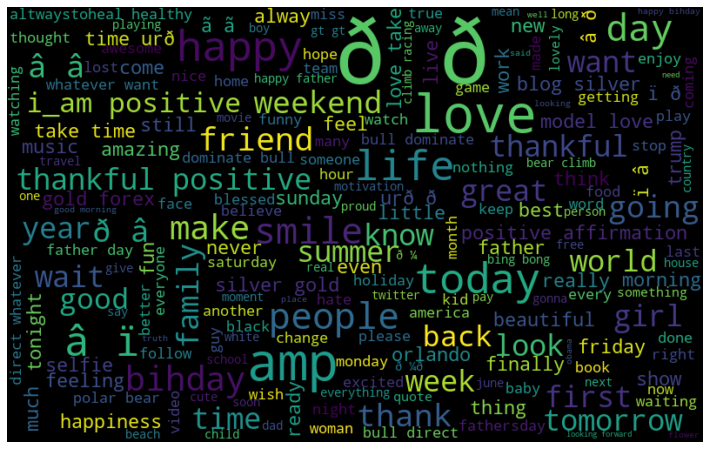

In [13]:
# Visualizing all words

all_words = " ".join(sent for sent in train['clean_text'])

from wordcloud import WordCloud
wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(all_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

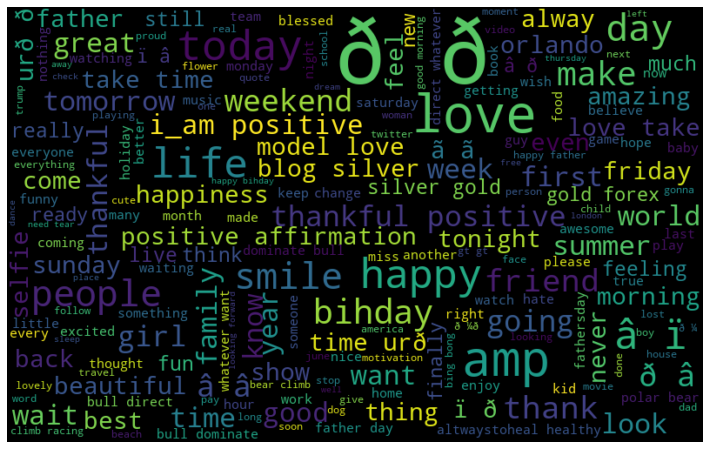

In [14]:
# Frequency of Positive Words

pos_words = " ".join(sent for sent in train['clean_text'][train['label'] == 0])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(pos_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

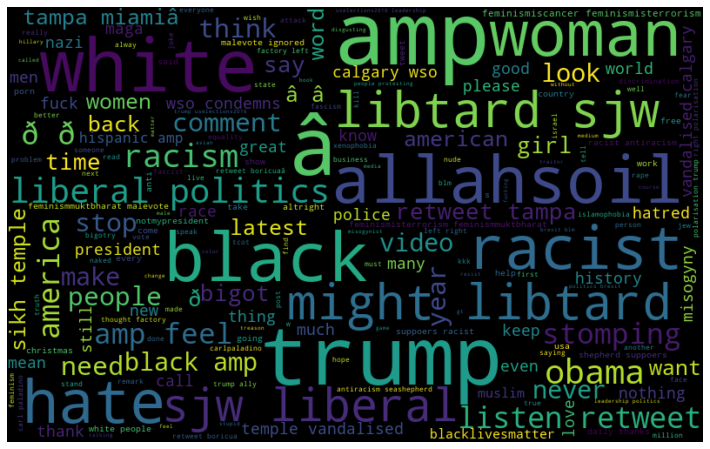

In [15]:
# Frequency of Negative Words

neg_words = " ".join(sent for sent in train['clean_text'][train['label'] == 1])

wordcloud = WordCloud(width=800, height=500, random_state=42, max_font_size=100).generate(neg_words)

plt.figure(figsize=(15,8))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis('off')
plt.show()

In [16]:
#Extract Hashtags

def extract_hashtag(texts):
    hash = []
    
    for text in texts:
        ht = re.findall(r"#(\w+)", text)
        hash.append(ht)
        
    return hash

In [17]:
hash_pos = extract_hashtag(train['clean_text'][train['label'] == 0])

In [18]:
hash_neg = extract_hashtag(train['clean_text'][train['label'] == 1])

In [19]:
hash_neg[:10]

[['cnn', 'michigan', 'tcot'],
 ['australia',
  'opkillingbay',
  'seashepherd',
  'helpcovedolphins',
  'thecove',
  'helpcovedolphins'],
 [],
 [],
 ['neverump', 'xenophobia'],
 ['love', 'peace'],
 [],
 ['race', 'identity', 'medâ'],
 ['altright', 'whitesupremacy'],
 ['linguistics', 'race', 'power', 'raciolinguistics']]

In [20]:
# unnest list
hash_pos = sum(hash_pos, [])
hash_neg = sum(hash_neg, [])

In [21]:
hash_pos[:10]

['run',
 'lyft',
 'disapointed',
 'getthanked',
 'model',
 'motivation',
 'allshowandnogo',
 'school',
 'exams',
 'hate']

In [22]:
freq = nltk.FreqDist(hash_pos)
pos = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
pos.head()

,Hashtag,Count
0,run,33
1,lyft,2
2,disapointed,1
3,getthanked,2
4,model,364


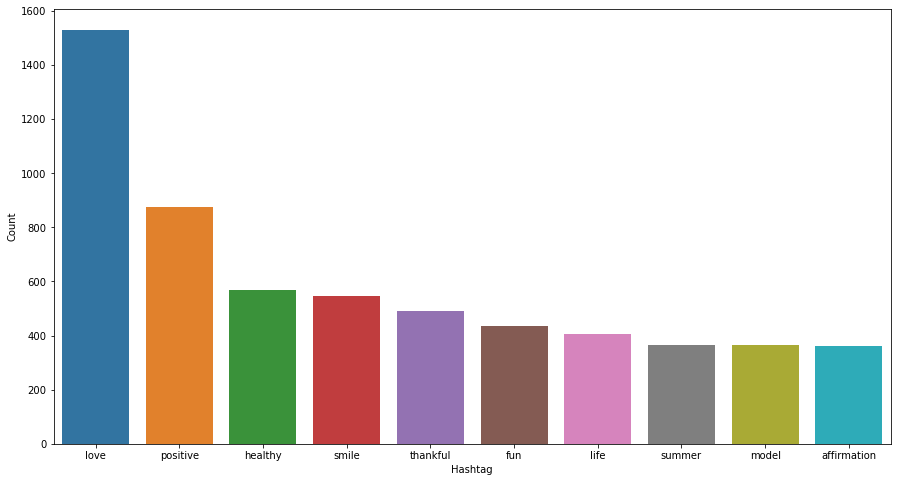

In [23]:
# select top 10 hashtags
pos = pos.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,8))
sns.barplot(data=pos, x='Hashtag', y='Count')
plt.show()

In [24]:
freq = nltk.FreqDist(hash_neg)
neg = pd.DataFrame({'Hashtag': list(freq.keys()),
                 'Count': list(freq.values())})
neg.head()

,Hashtag,Count
0,cnn,9
1,michigan,2
2,tcot,14
3,australia,6
4,opkillingbay,2


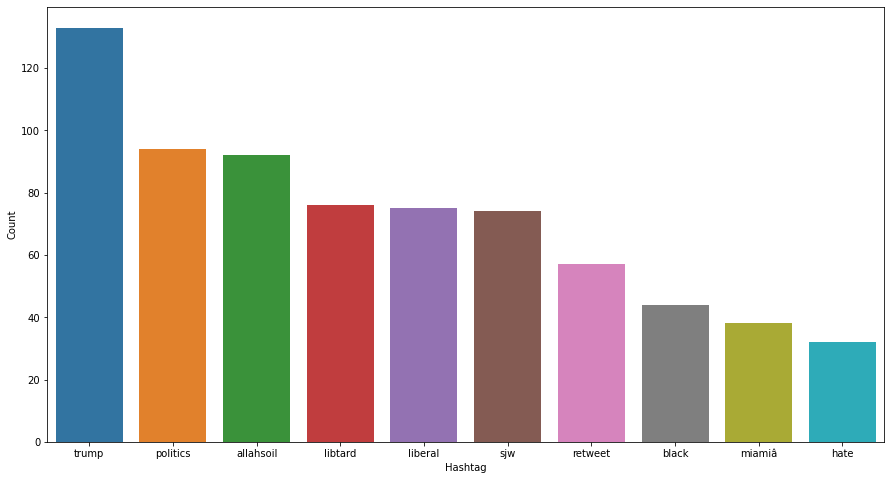

In [25]:
# select top 10 hashtags
neg = neg.nlargest(columns='Count', n=10)
plt.figure(figsize=(15,8))
sns.barplot(data=neg, x='Hashtag', y='Count')
plt.show()

In [26]:
# feature extraction
from sklearn.feature_extraction.text import CountVectorizer
bow_vectorizer = CountVectorizer(max_df=0.90, min_df=2, max_features=1000, stop_words='english')
bow = bow_vectorizer.fit_transform(train['clean_text'])

In [27]:
from sklearn.model_selection import train_test_split
xtrain, xtest, ytrain, ytest = train_test_split(bow, train['label'], random_state=42, test_size=0.25)

In [28]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score, accuracy_score

In [29]:
# training
model = LogisticRegression()
model.fit(xtrain, ytrain)

LogisticRegression()

In [30]:
# testing
pred = model.predict(xtest)
f1_score(ytest, pred)

0.4835965978128798

In [31]:
accuracy_score(ytest,pred)

0.9468151670629458

In [32]:
# use probability to get output
pred_prob = model.predict_proba(xtest)
pred = pred_prob[:, 1] >= 0.3
pred = pred.astype(np.int)

f1_score(ytest, pred)

C:\Users\SAIRAM~1\AppData\Local\Temp/ipykernel_9084/227074875.py:4: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  pred = pred.astype(np.int)


0.532520325203252

In [33]:
accuracy_score(ytest,pred)

0.9424352396446002